# Analysis of the rankings obtained in the sfhh-conference hypergraph

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import scienceplots

plt.style.use(['science', 'no-latex'])

from collections import defaultdict

In [2]:
df = pandas.read_csv("../../Output/sfhh-conference_dataframe.csv")

In [3]:
df.drop("AltUnif-2", axis=1, inplace=True)

We have to sort the columns before showing the KT plots. This is a bit more cumbersome than it should due to the alphabetical sorting.

In [4]:
def sortcolumns(df):

    labeldict = {"U":[], "H":[], "A":[]}
    for label in df.columns:
        if "UPHEC" in label:
            labeldict["U"].append(label)
        elif "Alt" in label:
            labeldict["A"].append(label)
        elif "CEC" not in label:
            labeldict["H"].append(label)
    
    # Sort UPHEC, AltUnif
    for key in ["U","A"]:
        labeldict[key] = sorted(labeldict[key])
    
    # Sort the remaining one according to its number
    Hmindex = [int(label.split("-")[1].split("u")[0]) for label in labeldict["H"]]
    labeldict["H"] = list(np.array(labeldict["H"])[np.argsort(Hmindex)])
     
    return df.reindex(["CEC"]+ labeldict["U"]+ labeldict["H"]+ labeldict["A"], axis=1)

In [5]:
df = sortcolumns(df)

In [6]:
#df[labeldict["U"] + labeldict["A"]]

In [7]:
df.sum() # consistency check

CEC          1.0
UPHEC-2      1.0
UPHEC-3      1.0
UPHEC-4      1.0
UPHEC-5      1.0
UPHEC-6      1.0
UPHEC-7      1.0
UPHEC-8      1.0
UPHEC-9      1.0
HEC-2unif    1.0
HEC-3unif    1.0
HEC-4unif    1.0
HEC-5unif    1.0
HEC-6unif    1.0
HEC-7unif    1.0
HEC-8unif    1.0
HEC-9unif    1.0
AltUnif-3    1.0
AltUnif-4    1.0
AltUnif-5    1.0
AltUnif-6    1.0
AltUnif-7    1.0
AltUnif-8    1.0
AltUnif-9    1.0
dtype: float64

In [8]:
#series2 = df["HEC-2unif"]
#series2[series2 > 0].count()

In [9]:
#series5 = df["AltUnif-5"]
#series5obtained

## Complete ranking - Kendall's tau

In [10]:
KT = np.zeros((len(df.columns),len(df.columns)))
for i, row in enumerate(df):
    for j, col in enumerate(df):
        KT[i,j] = scipy.stats.kendalltau(df[row],df[col]).statistic

In [11]:
np.min(KT)

-0.06842840216913561

In [12]:
def findInt(col):
    index = col.find("-")
    for n in [3,2,1]:
        try:
            M = int(col[index+1:index+n])
            return str(M)
        except:
            continue
labels = [str(col)[0]+findInt(col) for col in list(df.columns)[1:]]

type_dict = defaultdict(int)
for cent in labels:
    type_dict[cent[0]] += 1
    
separators = [type_dict["U"], type_dict["H"]+type_dict["U"]]

In [13]:
print(type_dict)

defaultdict(<class 'int'>, {'U': 8, 'H': 8, 'A': 7})


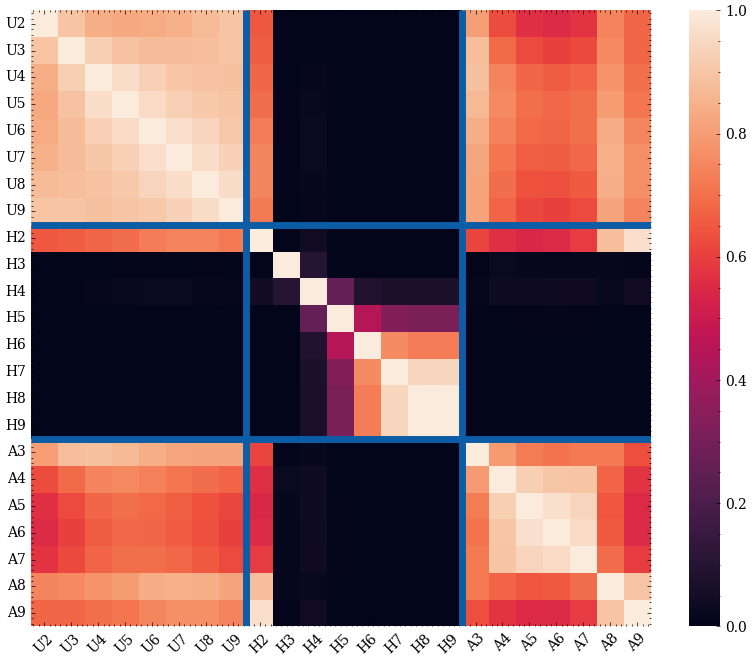

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax = sns.heatmap(KT[1:,1:], annot=False, vmin=0, vmax=1)

ax.hlines(separators, *ax.get_xlim(), linewidth=5)
ax.vlines(separators, *ax.get_ylim(), linewidth=5)

ax.set_yticklabels(labels, rotation=0)
ax.set_xticklabels(labels, rotation=45)

#plt.savefig("Figures/KT_heatmap.svg")

plt.show()

In [15]:
def drop_H(KT, type_dict, labels):
    """
    Keep only the parts corresponding to the UPHEC and the Blowup
    """

    lenu = type_dict["U"]
    lenh = type_dict["H"]
    lenuh = lenu + lenh
    lena = type_dict["A"]
    
    KT_reduced = np.zeros([lenu+lena,lenu+lena])

    # UU
    KT_reduced[0:lenu, 0:lenu] = KT[1:lenu+1,1:lenu+1]
    # UA, AU
    KT_reduced[0:lenu, lenu:lenu+lena] = KT[1:lenu+1,1+lenuh:1+lenuh+lena]
    KT_reduced[lenu:lenu+lena, 0:lenu] = KT[1+lenuh:1+lenuh+lena,1:lenu+1]
    # AA
    KT_reduced[lenu:lenu+lena, lenu:lenu+lena] = KT[1+lenuh:1+lenuh+lena,1+lenuh:1+lenuh+lena]

    labels_reduced = ["U2/B2"] + labels[1:lenu] + [lab.replace("A","B") for lab in labels[lenuh:lenuh+lena]]
    
    return KT_reduced, labels_reduced

KT_reduced, labels_reduced = drop_H(KT, type_dict, labels)

In [16]:
labels_reduced

['U2/B2',
 'U3',
 'U4',
 'U5',
 'U6',
 'U7',
 'U8',
 'U9',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9']

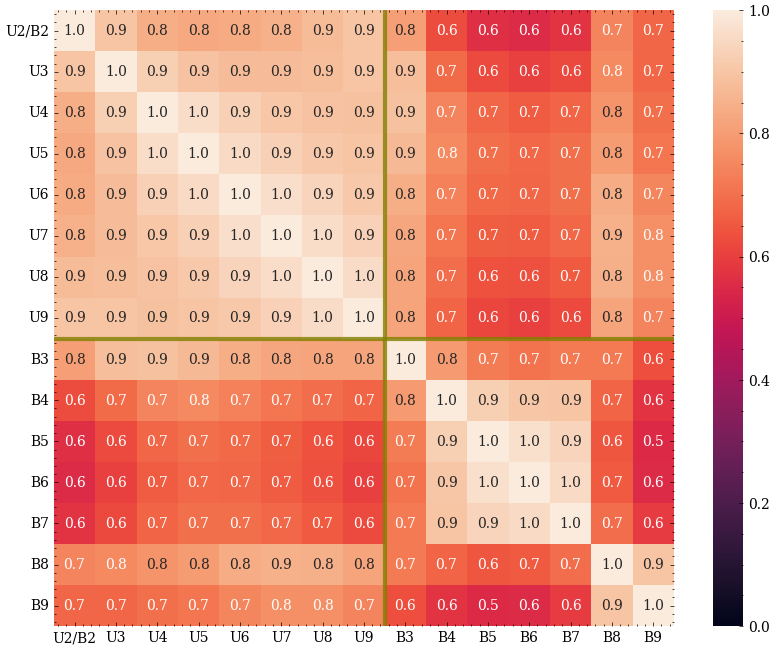

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax = sns.heatmap(KT_reduced, annot=True, fmt=".1f", vmin=0, vmax=1)

ax.hlines(type_dict["U"], *ax.get_xlim(), linewidth=3, color='olive',alpha=0.8)
ax.vlines(type_dict["U"], *ax.get_ylim(), linewidth=3, color='olive',alpha=0.8)

ax.set_yticklabels(labels_reduced, rotation=0)
ax.set_xticklabels(labels_reduced, rotation=0)

plt.savefig("../../Figures/KT-SFHH_reduc_heatmap.svg")

plt.show()

## Top-K ranking


In [15]:
## Top K nodes based on a centrality dictionary ##
def topK(cent, K=None, return_list=False):
    """
    Given a dictionary node-centrality score, return the top K ranking
    """

    if not K:
        K = len(cent)
    
    C = sorted(cent, key=cent.get, reverse=True)[:K]
    ranking = {key: cent[key] for key in C}
    
    if return_list:
        return C

    return ranking

In [16]:
dictlist = df.to_dict()

In [17]:
for key1, value1 in dictlist.items():
    print(key1, topK(value1,K=10).keys())

CEC dict_keys([389, 257, 385, 299, 308, 93, 366, 345, 322, 59])
UPHEC-2 dict_keys([389, 257, 385, 299, 308, 93, 366, 345, 322, 59])
UPHEC-3 dict_keys([389, 385, 257, 308, 299, 93, 366, 345, 322, 59])
UPHEC-4 dict_keys([389, 385, 308, 257, 93, 299, 366, 322, 345, 59])
UPHEC-5 dict_keys([389, 385, 308, 257, 93, 299, 366, 322, 345, 59])
UPHEC-6 dict_keys([389, 385, 308, 257, 93, 366, 299, 59, 322, 345])
UPHEC-7 dict_keys([389, 385, 308, 93, 257, 366, 299, 59, 322, 345])
UPHEC-8 dict_keys([389, 385, 308, 93, 257, 366, 299, 59, 322, 345])
UPHEC-9 dict_keys([389, 385, 308, 93, 257, 366, 299, 59, 322, 345])
HEC-2unif dict_keys([226, 15, 320, 149, 195, 27, 393, 223, 163, 275])
HEC-3unif dict_keys([305, 82, 76, 142, 351, 102, 143, 97, 80, 185])
HEC-4unif dict_keys([45, 56, 127, 193, 125, 222, 85, 41, 84, 77])
HEC-5unif dict_keys([74, 72, 50, 42, 52, 56, 63, 14, 68, 6])
HEC-6unif dict_keys([4, 13, 15, 9, 0, 3, 11, 14, 6, 7])
HEC-7unif dict_keys([10, 9, 2, 3, 5, 8, 4, 6, 7, 0])
HEC-8unif dict_key

In [18]:
KTtopK = defaultdict(list)

for key1, value1 in dictlist.items():
    
    print("Comparing", key1, "against the rest.")
    
    for key2, value2 in dictlist.items():
        
        if key1 == key2:
            continue
        
        for k in range(1, len(df)):
                        
            topk1 = topK(value1, K=k)
            centrals2 = [value2[node] for node in topk1.keys()]
            
            KTtopK[key1 + " -> " + key2].append( scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic )

Comparing CEC against the rest.
Comparing UPHEC-2 against the rest.
Comparing UPHEC-3 against the rest.
Comparing UPHEC-4 against the rest.
Comparing UPHEC-5 against the rest.
Comparing UPHEC-6 against the rest.
Comparing UPHEC-7 against the rest.
Comparing UPHEC-8 against the rest.
Comparing UPHEC-9 against the rest.
Comparing HEC-2unif against the rest.
Comparing HEC-3unif against the rest.
Comparing HEC-4unif against the rest.
Comparing HEC-5unif against the rest.
Comparing HEC-6unif against the rest.
Comparing HEC-7unif against the rest.
Comparing HEC-8unif against the rest.
Comparing HEC-9unif against the rest.
Comparing AltUnif-3 against the rest.
Comparing AltUnif-4 against the rest.
Comparing AltUnif-5 against the rest.
Comparing AltUnif-6 against the rest.
Comparing AltUnif-7 against the rest.
Comparing AltUnif-8 against the rest.
Comparing AltUnif-9 against the rest.


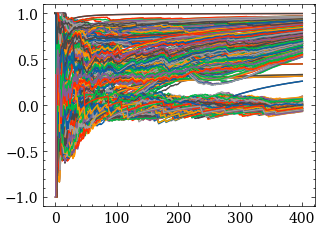

In [19]:
for key, val in KTtopK.items():
    plt.plot(val, label=key)
    
#plt.legend()